In [1]:
import os
import pandas as pd

print("=" * 70)
print("GENERATING MANIFEST.CSV")
print("=" * 70)

# Data path
base_path = r'data_recordings'

print(f"\n Base path: {base_path}")

rows = []

print("\n Processing ACCEPTED...")
accepted_folder = os.path.join(base_path, 'accepted')
if os.path.exists(accepted_folder):
    for speaker_folder in os.listdir(accepted_folder):
        speaker_path = os.path.join(accepted_folder, speaker_folder)
        if os.path.isdir(speaker_path):
            file_count = 0
            for file in os.listdir(speaker_path):
                if file.endswith(('.wav', '.mp3', '.flac')):
                    relative_path = os.path.join('accepted', speaker_folder, file)
                    rows.append({
                        'speaker_id': speaker_folder,
                        'path': relative_path,
                        'label': 1  # 1 = ACCEPTED
                    })
                    file_count += 1
            print(f"{speaker_folder}: {file_count} files")
else:
    print(f"Not found: {accepted_folder}")

print("\nProcessing REJECTED...")
rejected_folder = os.path.join(base_path, 'rejected')
if os.path.exists(rejected_folder):
    for speaker_folder in os.listdir(rejected_folder):
        speaker_path = os.path.join(rejected_folder, speaker_folder)
        if os.path.isdir(speaker_path):
            file_count = 0
            for file in os.listdir(speaker_path):
                if file.endswith(('.wav', '.mp3', '.flac')):
                    relative_path = os.path.join('rejected', speaker_folder, file)
                    rows.append({
                        'speaker_id': speaker_folder,
                        'path': relative_path,
                        'label': 0  # 0 = REJECTED
                    })
                    file_count += 1
            print(f"  {speaker_folder}: {file_count} files")
else:
    print(f" Not found: {rejected_folder}")

df = pd.DataFrame(rows)
manifest_file = os.path.join(base_path, 'manifest.csv')
df.to_csv(manifest_file, index=False)

print("\n" + "=" * 70)
print("MANIFEST GENERATED SUCCESFULLY")
print("=" * 70)
print(f"\nArchive: {manifest_file}")
print(f"Total archives: {len(df)}")
print(f"  • Accepted (label=1): {sum(df['label'] == 1)}")
print(f"  • Rejected (label=0): {sum(df['label'] == 0)}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nColumns: {df.columns.tolist()}")


GENERATING MANIFEST.CSV

 Base path: data_recordings

 Processing ACCEPTED...
p001: 242 files
p226: 276 files
p227: 303 files
p228: 274 files
p230: 287 files
p233: 296 files

Processing REJECTED...
  p231: 107 files
  p232: 96 files
  p236: 102 files
  p239: 99 files
  p243: 82 files
  p244: 97 files
  p250: 103 files
  p254: 90 files
  p256: 86 files
  p257: 103 files
  p258: 92 files
  p259: 91 files
  p267: 98 files
  p268: 92 files
  p269: 90 files
  p270: 86 files
  p273: 94 files
  p274: 91 files
  p276: 88 files
  p277: 89 files

MANIFEST GENERATED SUCCESFULLY

Archive: data_recordings\manifest.csv
Total archives: 3554
  • Accepted (label=1): 1678
  • Rejected (label=0): 1876

First 5 rows:
  speaker_id                        path  label
0       p001  accepted\p001\p001_001.wav      1
1       p001  accepted\p001\p001_002.wav      1
2       p001  accepted\p001\p001_003.wav      1
3       p001  accepted\p001\p001_004.wav      1
4       p001  accepted\p001\p001_005.wav      1

Colu

In [3]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split   # kept, though no longer used
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("SPEAKER VERIFICATION - CNN WITH MEL-SPECTROGRAMS")
print("=" * 70)


# Initialization of paths
base_path = r'data_recordings'
manifest_path = os.path.join(base_path, 'manifest.csv')


MAX_SAMPLES = None # TODO what's this?

# Activating dropout
dropout = False
dropout_low = False

# ### Ratios for 3-way split
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_STATE = 42 # TODO what's this?




print(f"\nConfiguration:")
print(f"  Base path: {base_path}")
print(f"  Manifest: {manifest_path}")
print(f"  Max samples: {MAX_SAMPLES if MAX_SAMPLES else 'All'}")
print(f"  Split ratios (train/val/test): {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")

print("\n" + "=" * 70)
print("VERIFYING FILES AND PATHS")
print("=" * 70)

# Checking base folder and manifest
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Base folder not found: {base_path}")
print("Base folder found")

if not os.path.exists(manifest_path):
    print("\nPlease run first: python run_pipeline_to_get_data.py")
    raise FileNotFoundError("manifest.csv not found")
print("Manifest found")




print("\n" + "=" * 70)
print("STEP 1: LOADING DATA FROM MANIFEST.CSV")
print("=" * 70)

df = pd.read_csv(manifest_path)
print(f"\nTotal entries: {len(df)}")

if MAX_SAMPLES:
    df = df.head(MAX_SAMPLES)

print(f"\nFirst 5 rows:")
print(df.head())

if 'path' not in df.columns or 'label' not in df.columns:
    raise ValueError("Incorrect manifest format")

print(f"\nClass distribution:")
print(f"  Accepted: {sum(df['label'] == 1)}")
print(f"  Rejected: {sum(df['label'] == 0)}")

# ### Extract speaker ID from the path
# Assumes something like: accepted/p001/file.wav  -> speaker 'p001'
df['speaker'] = df['path'].apply(lambda p: os.path.basename(os.path.dirname(p)))

print("\nNumber of unique speakers:", df['speaker'].nunique())
print("Sample speakers:", df['speaker'].unique()[:10])

def load_audio_file(file_path, base_folder, sr=22050, max_duration=3):
    full_path = os.path.join(base_folder, file_path)
    try:
        y, _ = librosa.load(full_path, sr=sr, duration=max_duration)
        y = y / (np.max(np.abs(y)) + 1e-6)
        y, _ = librosa.effects.trim(y, top_db=20)
        
        target_length = sr * max_duration
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        else:
            y = y[:target_length]
        return y
    except:
        return None

print("\n" + "=" * 70)
print("STEP 2: LOADING AUDIO FILES")
print("=" * 70)

audio_data = []
labels = []
speakers = []   # keep track of speaker for each loaded sample
failed = 0

for idx, row in df.iterrows():
    audio = load_audio_file(row['path'], base_path)
    if audio is not None:
        audio_data.append(audio)
        labels.append(row['label'])
        speakers.append(row['speaker'])
    else:
        failed += 1
    
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{len(df)} files...")

print(f"\nLoading completed: {len(audio_data)} files")
if failed > 0:
    print(f"Failed: {failed}")

if len(audio_data) == 0:
    raise ValueError("No data to train")



print("\n" + "=" * 70)
print("STEP 3: GENERATING MEL-SPECTROGRAMS")
print("=" * 70)

def audio_to_spectrogram(y, sr=22050, n_mels=128):
    # Function for creating spectrograms from audio files
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db[..., np.newaxis]

spectrograms = []
for i, audio in enumerate(audio_data):
    spectrograms.append(audio_to_spectrogram(audio))
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_data)} spectrograms...")

spectrograms = np.array(spectrograms)
labels = np.array(labels)
speakers = np.array(speakers)

print(f"\nSpectrograms shape: {spectrograms.shape}")

def _get_recording_group_key(path, speaker):
    """
    Given a relative path like 'accepted/p226/p226_003_000.wav',
    return a deterministic group key.

    For most speakers: group by (speaker, original_recording_id) where
    original_recording_id is the middle number in 'p226_003_000'.

    For accepted/p001: treat each file as its own group (no special grouping).
    """
    norm_path = path.replace("\\", "/")
    basename = os.path.basename(norm_path)
    stem, _ = os.path.splitext(basename)
    parts = stem.split("_")

    # Special case: manual recordings
    if "/accepted/" in norm_path and speaker == "p001":
        return f"{speaker}|{stem}"

    # Typical auto-split pattern: pXXX_###_###
    if len(parts) >= 3 and parts[0] == speaker and parts[1].isdigit() and parts[2].isdigit():
        # use the middle number as "original recording" id
        original_id = parts[1]               
        return f"{speaker}|{original_id}"



def split_by_speaker_and_recording(
    X, y, speakers,
    train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
):
    """
    3-way split:
      - per speaker
      - keeping all segments from the same original recording together
      - except for manual recordings TODO why?
    """

    # Checking if data is loaded succesfully
    if not (len(X) == len(y) == len(speakers)):
        raise ValueError("X, y and speakers must have the same length")

    # We rely on the fact that each loaded sample corresponds to the same row in df.
    # If some files failed to load, we stop rather than mis-align.
    if 'failed' in globals() and failed != 0:
        raise ValueError(
            "Splitting assumes all files loaded successfully (failed == 0). "
            "Got failed != 0; please adjust loading logic or splitting."
        )
    if len(df) != len(X):
        raise ValueError(
            f"Length mismatch between df ({len(df)}) and data ({len(X)}). "
            "Splitting by recording cannot be done safely."
        )

    # Build groups: (speaker, recording_group_key) -> list of sample indices
    groups_per_speaker = {} 
    for idx, spk in enumerate(speakers):
        path = df.loc[idx, "path"]
        group_key = _get_recording_group_key(path, spk)

        if spk not in groups_per_speaker:
            groups_per_speaker[spk] = {}
        if group_key not in groups_per_speaker[spk]:
            groups_per_speaker[spk][group_key] = []
        groups_per_speaker[spk][group_key].append(idx)

    train_idx, val_idx, test_idx = [], [], []

    for spk in sorted(groups_per_speaker.keys()):
        group_dict = groups_per_speaker[spk]
        grouped_items = sorted(group_dict.items(), key=lambda kv: kv[0])

        # Total samples for this speaker
        all_indices = [i for _, idxs in grouped_items for i in idxs]
        n_total = len(all_indices)

        target_train = int(round(train_ratio * n_total))
        target_val = int(round(val_ratio * n_total))
        n_train = n_val = 0

        for group_key, idxs in grouped_items:
            gsize = len(idxs)

            if n_train + gsize <= target_train:
                train_idx.extend(idxs)
                n_train += gsize
            elif n_val + gsize <= target_val:
                val_idx.extend(idxs)
                n_val += gsize
            else:
                test_idx.extend(idxs)

    train_idx = np.array(sorted(train_idx))
    val_idx = np.array(sorted(val_idx))
    test_idx = np.array(sorted(test_idx))

    return (
        X[train_idx], X[val_idx], X[test_idx],
        y[train_idx], y[val_idx], y[test_idx]
    )


X_train, X_val, X_test, y_train, y_val, y_test = split_by_speaker_and_recording(
    spectrograms,
    labels,
    speakers,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO
)

print(f"\nFinal split sizes:")
print(f"  Train:      {X_train.shape[0]}")
print(f"  Validation: {X_val.shape[0]}")
print(f"  Test:       {X_test.shape[0]}")

SPEAKER VERIFICATION - CNN WITH MEL-SPECTROGRAMS

Configuration:
  Base path: data_recordings
  Manifest: data_recordings\manifest.csv
  Max samples: All
  Split ratios (train/val/test): 0.7/0.15/0.15

VERIFYING FILES AND PATHS
Base folder found
Manifest found

STEP 1: LOADING DATA FROM MANIFEST.CSV

Total entries: 3554

First 5 rows:
  speaker_id                        path  label
0       p001  accepted\p001\p001_001.wav      1
1       p001  accepted\p001\p001_002.wav      1
2       p001  accepted\p001\p001_003.wav      1
3       p001  accepted\p001\p001_004.wav      1
4       p001  accepted\p001\p001_005.wav      1

Class distribution:
  Accepted: 1678
  Rejected: 1876

Number of unique speakers: 26
Sample speakers: ['p001' 'p226' 'p227' 'p228' 'p230' 'p233' 'p231' 'p232' 'p236' 'p239']

STEP 2: LOADING AUDIO FILES
  Processed 50/3554 files...
  Processed 100/3554 files...
  Processed 150/3554 files...
  Processed 200/3554 files...
  Processed 250/3554 files...
  Processed 300/3554 f


STEP 4: BUILDING AND TRAINING CNN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 128, 130, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 130, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,147,396 (65.41 MB)

 Trainable params: 17,147,393 (65.41 MB)

 Non-trainable params: 3 (16.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 103s 695ms/step - accuracy: 0.5831 - loss: 0.7104 - val_accuracy: 0.6734 - val_loss: 0.5574 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 103s 713ms/step - accuracy: 0.8351 - loss: 0.3579 - val_accuracy: 0.8548 - val_loss: 0.3198 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 139s 691ms/step - accuracy: 0.9163 - loss: 0.2015 - val_accuracy: 0.8810 - val_loss: 0.2775 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 106s 731ms/step - accuracy: 0.9478 - loss: 0.1292 - val_accuracy: 0.9294 - val_loss: 0.1822 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to

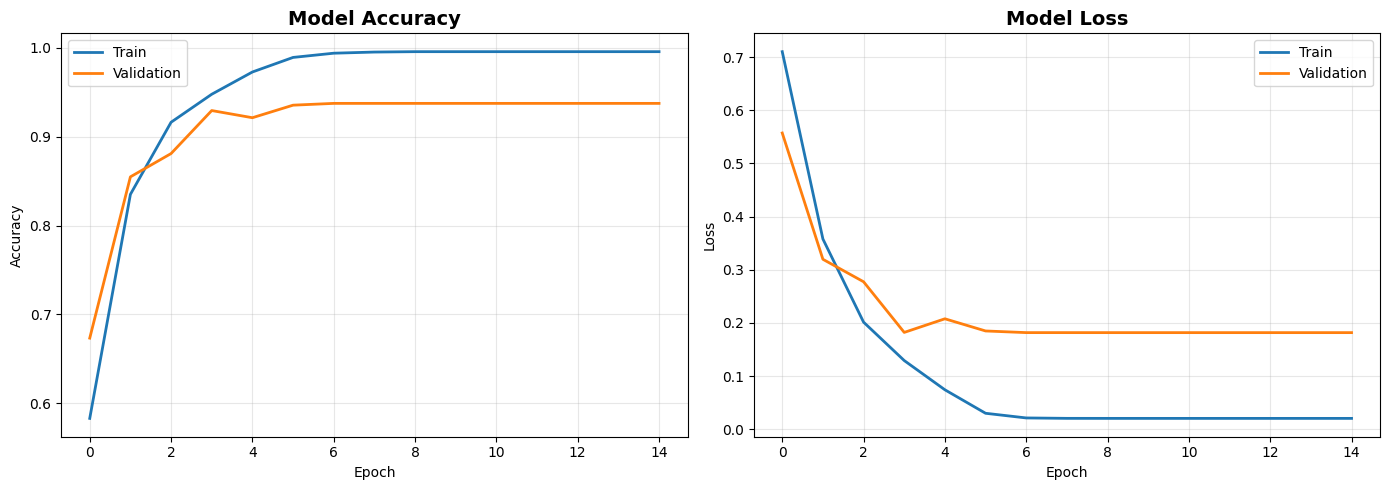

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step

TEST ACCURACY: 68.42%

              precision    recall  f1-score   support

    Rejected       0.55      0.93      0.69       282
    Accepted       0.93      0.53      0.68       459

    accuracy                           0.68       741
   macro avg       0.74      0.73      0.68       741
weighted avg       0.78      0.68      0.68       741



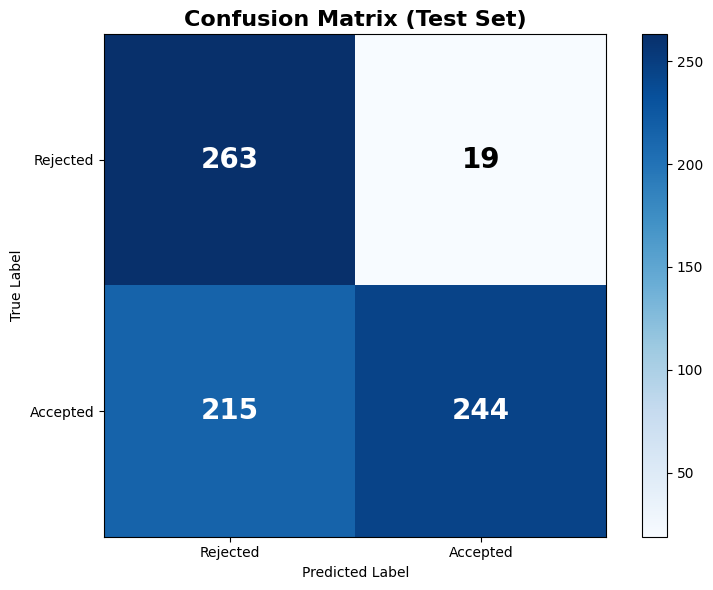


TRAINING COMPLETED SUCCESSFULLY!

Generated files:
  • training_history.png
  • confusion_matrix.png
  • test_results.csv
  • speaker_verification_model.h5


In [4]:
print("\n" + "=" * 70)
print("STEP 4: BUILDING AND TRAINING CNN")
print("=" * 70)


norm_layer = layers.Normalization()
norm_layer.adapt(X_train)


# Building models

def build_cnn_model(input_shape, norm):
    # default model (without dropout or anything)
    return models.Sequential([
        layers.Input(shape=input_shape),
        norm,
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),   # before 32
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # before 64
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # before 128
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),                           # before 128
        layers.Dense(1, activation='sigmoid')
    ])

#This already allows you to say that you have tested architectures with different layer depths and sizes.

'''
def build_cnn_model(input_shape, norm):
    # default model with batch normalization
    return models.Sequential([
        layers.Input(shape=input_shape),
        norm,

        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(1, activation='sigmoid')
    ])
'''

def build_cnn_model_dropout(input_shape, norm):
    # model with dropout
    return models.Sequential([
        layers.Input(shape=input_shape),
        norm,
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

def build_cnn_model_dropout_low(input_shape, norm):
    # model with low dropout (for comparison)
    return models.Sequential([
        layers.Input(shape=input_shape),
        norm,
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])


# Checking which model to use
if (dropout):
    model = build_cnn_model_dropout(X_train.shape[1:], norm_layer)
elif(dropout_low):
    model = build_cnn_model_dropout_low(X_train.shape[1:], norm_layer)
else:
    model = build_cnn_model(X_train.shape[1:], norm_layer)

# Show model
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# If training is fast, we can stop early
# TODO check if values can be improved
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)
def lr_scheduler(epoch, lr):
    # mantiene el LR hasta la época 5 y luego lo reduce 10x
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val), 
    epochs=15,
    batch_size=16,
    callbacks=[early_stop, lr_callback],
    verbose=1
)

'''
This step helps the model learn faster at the beginning and then fine‑tune more 
carefully later by automatically reducing the learning rate during training, 
which can improve convergence stability and final accuracy. 
'''

print("\n" + "=" * 70)
print("STEP 5: EVALUATION AND RESULTS (ON TEST SET)")
print("=" * 70)


#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTEST ACCURACY: {test_accuracy*100:.2f}%\n")
print(classification_report(y_test, y_test_pred, target_names=['Rejected', 'Accepted']))

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')
plt.colorbar()

classes = ['Rejected', 'Accepted']
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes)

thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20, fontweight='bold')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

results_df = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_test_pred,
    'confidence': y_test_pred_prob.flatten()
})
results_df.to_csv('test_results.csv', index=False)

# Saving model
model.save('speaker_verification_model.h5')


print("\n" + "=" * 70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("\nGenerated files:")
print("  • training_history.png")
print("  • confusion_matrix.png")
print("  • test_results.csv")
print("  • speaker_verification_model.h5")
